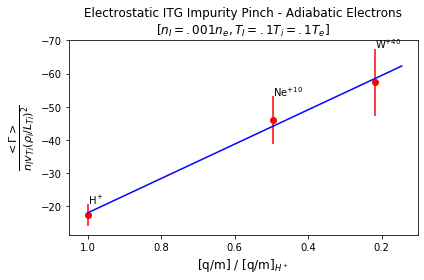

In [4]:
# %load plotFluxes.py
#!/usr/bin/env python

import numpy as np
import numpy.polynomial.polynomial as poly
import math
import matplotlib.pyplot as plt
from plotFlux import readFlux
from plotFlux import getAverageVal
from plotFlux import getData
from plotFlux import getStdDev

#Set data flags for script.
#User input flags - just change these input flags if you want to ignore every choice until runtime.
allowGeneralInput = False #Accept input for all other flags.
allowParamInput   = False #Accept tokamak param. input.
#Data type flag. Set one or both true. For kinetic, adiabatic, or both electron data.
adiabaticData = True
kineticData   = False
#Normalization flags. Set at most one true. None gives GENE norm.
impNormFlag = True  #Convert GENE norm to nicer impurity norm using L_T and n_imp.
expNormFlag = False #Convert GENE norm to experimental norm.
#Flux data types
particleFlux = 0
heatFlux     = 1
momentumFlux = 2
fluxType  = particleFlux

#Data indices to use when gathering info.
names     = 0
files     = 1
qmRat     = 2
densRat   = 3
startT    = 4
omt       = 5
dataSet   = 6
dataSetColor = 7
dataFitColor = 8
#Normalization types
experimentalNorm = "ExpNorm"
impurityNorm     = "ImpNorm"
geneNorm         = "GB" #GyroBohm norm.

#Data sets.
kineticDataSet =   [["H$^+$", "Custom$^{+6}$", "Be$^{+4}$", "Ne$^{+10}$", "Ar$^{+15}$", "Mo$^{+31}$", "W$^{+40}$"],
                    ["./GoerlerImpurities/nrgsummary_proton.dat",     "./GoerlerImpurities/nrgsummary_custom.dat",
                     "./GoerlerImpurities/nrgsummary_beryllium.dat",  "./GoerlerImpurities/nrgsummary_neon.dat",
                     "./GoerlerImpurities/nrgsummary_argon.dat",      "./GoerlerImpurities/nrgsummary_molybdenum.dat",
                     "./GoerlerImpurities/nrgsummary_tungsten.dat"],
                    [1/1, 6/8, 4/9.0121820, 10/20.17970, 15/39.948, 31/95.95, 40/183.84],
                    [.001, .001, .001, .001, .001, .001, .001],
                    [.53, .64, .37, .16, .16, .13, .16],
                    [6.96, 6.96, 6.96, 6.96, 6.96, 6.96, 6.96],
                    "kinetic",
                    "steelblue",
                    "red"]
adiabaticDataSet = [["H$^+$", "Ne$^{+10}$", "W$^{+40}$"],
                    ["./GoerlerImpurities/nrgsummary_proton_ad.dat", "./GoerlerImpurities/nrgsummary_neon_ad.dat",
                     "./GoerlerImpurities/nrgsummary_tungsten_ad.dat"],
                    [1/1, 10/20.17970, 40/183.84],
                    [.001, .001, .001],
                    [.114, .25, .118],
                    [6.96, 6.96, 6.96],
                    "adiabatic",
                    "red",
                    "blue"]

#Accept user input before running main routine.
# Parameters are all obtained from Callen Nuc. Fusion 2010 by Scott
# This is a DIII-D H-mode before the onset of an ELM
R0  = 1.7    # Magnetic axis, meters
R   = 2.2    # location of cold impurities, near separatrix
B0  = 2.     # Teslas, B at R0
mu  = 2.     # m/mp for bulk ions - I use mu=2 because tokamaks typically run with D.
Z   = 1.     # This is Z for the bulk ions
Ti  = 1000.  # bulk ion temp in eV at cold impurity location
c   = 0.001  # c=nI/n0, concentration of impurity
if (allowGeneralInput):
   #Reset all flags so defaults above don't screw things up.
   adiabaticData = False
   kineticData   = False
   impNormFlag   = False
   expNormFlag   = False
   #Read flags from input.
   adiabaticData = input("Plot data for adiabatic electrons? (y/n): ") == "y"
   kineticData   = input("Plot data for kinetic electrons? (y/n): ")   == "y"
   dataType      = int(input("Choose a flux type. (0 = particle flux (only one working), 1 = heat flux, 2 = momentum flux): "))
   normalization = int(input("Choose a normalization. (0 = GENE, 1 = impurity (L_ref = L_T, n_ref = n_I), 2 = experimental): "))
   #Reset normalization flags and set from input.
   if (normalization == 1):
      impNormFlag = True
   elif (normalization == 2):
      expNormFlag = True
   

if (allowParamInput):
   paramInput = input("Would you like to input necessary tokamak parameters? (y/n): ")
   if (paramInput == "y"):
      R0 = float(input("Major radius R0 (m): "))
      R  = float(input("Edge radius R (m): "))
      B0 = float(input("Background B field (T): "))
      mu = float(input("Bulk ion to proton mass ratio: "))
      Z  = float(input("Bulk ion charge factor Z: "))
      Ti = float(input("Bulk ion temp (eV): "))
      c  = float(input("Impurity concentration, n_I/n_e: "))

#Function for converting flux to SI units with DIII-D params - by Scott.
def getExpFactor():
   # Flux = Flux_GENE x n0 vt (rhoi/R)^2
   # R=L_ref, n0=n_ref, vt=vt_ref, rhoi_ref
   # vt=979.0/sqrt(mu) x sqrt(Ti)
   # rhoi=1.02 x sqrt(mu Ti)/(Z B)
   # factor= Flux/(nI*Flux_GENE) = 1/c vt (rhoi/R)^2

   # a little tricky... We want v_pinch.  Flux = v_pinch x nI
   # Flux_GENE = v_pinch x n0.  v_pinch = Flux_GENE/(nI/n0) x vt (rhoi/R)^2

   B = B0*R0/R*10000. # Plasma formulary formulas use Gauss
   rhoi = 1.02*np.sqrt(mu*Ti)/(Z*B)
   vti=9790.*np.sqrt(Ti/mu)

   factor = vti/c*(rhoi/R)**2.
   return factor

#Function for reading and plotting data set.
def readAndPlotFlux(ionData):
   #Read flux data from files - see data sets below for indices.
   ionNames        = ionData[names]
   ionFiles        = ionData[files]
   ionStartTs      = ionData[startT]
   ion_qmRats      = ionData[qmRat]
   ion_omts        = ionData[omt]
   ionDensRats     = ionData[densRat]
   ionDataSet      = ionData[dataSet]
   ionDataSetColor = ionData[dataSetColor]
   ionDataFitColor = ionData[dataFitColor]
   avgFlux    = []
   stdDev     = []

   #Read flux data.
   for i,ion in enumerate(ionNames):
      allFluxData = []
      readFlux(ionFiles[i], allFluxData)
      [t, fluxData] = getData(fluxType, allFluxData)
      startIndex = math.ceil(ionStartTs[i]*len(fluxData)) #Get index closest to startT fraction of total time.
      fluxData = np.array(fluxData[startIndex:]) #Need to make a numpy array to perform multiplication by a scalar...
      if (expNormFlag):
         fluxData = fluxData*getExpFactor()
      elif (impNormFlag):
         fluxData = fluxData * ((1/ion_omts[i])**2) * (1/ionDensRats[i]) #Normalize flux for L_T and n_imp.
      avgFlux.append(getAverageVal(fluxData))
      stdDev.append(getStdDev(fluxData))
   
   #Plot ion points.
   plt.scatter(ion_qmRats, avgFlux, color=ionDataSetColor)
   plt.errorbar(ion_qmRats, avgFlux, yerr=stdDev, linestyle="None", color=ionDataSetColor)

   for i, txt in enumerate(ionNames):
       ax.annotate(txt, (ion_qmRats[i], avgFlux[i] - stdDev[i])) #Offset y for readability.

   #Generate line of best fit.
   ion_qmRatsNew = np.linspace(ion_qmRats[-1]/1.5, 1, 100) #Note: Extend low end a little past last point.
   coeffs = poly.polyfit(ion_qmRats, avgFlux, 1)
   ffit   = poly.polyval(ion_qmRatsNew, coeffs)
   plt.plot(ion_qmRatsNew, ffit, color=ionDataFitColor, label=ionDataSet)

   textSize = 12
   largeTextSize = 16
   plt.xlabel("[q/m] / [q/m]$_{H^+}$", fontsize=textSize)
   if (expNormFlag):
      plt.ylabel("$v_{pinch}$ (m/s)",  fontsize=textSize)
   elif (impNormFlag):
      plt.ylabel("$\\frac{<\\Gamma>}{n_Iv_{Ti}(\\rho_i/L_{Ti})^2}$", fontsize=largeTextSize)
   else:
      plt.ylabel("<$\\Gamma$$_{GB}$>", fontsize=textSize)

#Main routine starts.

#Create figure and plot data.
fig, ax = plt.subplots()
if (kineticData):
   readAndPlotFlux(kineticDataSet)
if (adiabaticData):
   readAndPlotFlux(adiabaticDataSet)

label  = ""
if (kineticData and adiabaticData):
   plt.legend(loc='upper left')
   plt.title("Electrostatic ITG Impurity Pinch\n[$n_I=.001n_e, T_I=.1T_i=.1T_e$]")
elif (adiabaticData):
   plt.title("Electrostatic ITG Impurity Pinch - Adiabatic Electrons\n[$n_I=.001n_e, T_I=.1T_i=.1T_e$]")
elif (kineticData):
   plt.title("Electrostatic ITG Impurity Pinch - Kinetic Electrons\n[$n_I=.001n_e, T_I=.1T_i=.1T_e$]")

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()

#Get norm type in string form for file saving.
normType = ""
if (impNormFlag):
   normType = impurityNorm
elif (expNormFlag):
   normType = experimentalNorm
else:
   normType = geneNorm

if (kineticData and adiabaticData):
   plt.savefig('./GoerlerImpurities/FluxPlotAdKinEl' + normType + '.pdf')
elif (adiabaticData):
   plt.savefig('./GoerlerImpurities/FluxPlotAdEl'    + normType + '.pdf')
elif (kineticData):
   plt.savefig('./GoerlerImpurities/FluxPlotKinEl'   + normType + '.pdf')

plt.show()